## import lib

In [87]:
from collections import defaultdict
import csv
import numpy as np
from scipy import signal
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

## helper function

## read data to pandas Data frame

In [93]:
np.set_printoptions(precision=4)
pd.set_option('precision', 4)
util_df = pd.read_csv('data_clean.csv', na_filter=False)
print(util_df.head())

       ID               Name  Age Nationality  Overall  Potential  \
0  158023           L. Messi   31   Argentina       94         94   
1   20801  Cristiano Ronaldo   33    Portugal       94         94   
2  190871          Neymar Jr   26      Brazil       92         93   
3  192985       K. De Bruyne   27     Belgium       91         92   
4  183277          E. Hazard   27     Belgium       91         91   

                  Club    Value   Wage  Special  ...  Aggression  \
0         FC Barcelona  €110.5M  €565K     2202  ...          48   
1             Juventus     €77M  €405K     2228  ...          63   
2  Paris Saint-Germain  €118.5M  €290K     2143  ...          56   
3      Manchester City    €102M  €355K     2281  ...          76   
4              Chelsea     €93M  €340K     2142  ...          54   

   Interceptions  Positioning Vision  Penalties Composure  Marking  \
0             22           94     94         75        96       33   
1             29           95     82

## calculate team features 

In [94]:
# exponential weight
M = 200
tau = 5.0
w = signal.exponential(M, 0, tau, False)
weight_func = lambda x: np.average(x.sort_values(ascending=False, inplace=False), weights=w[:np.size(x, 0)])

team_df = pd.DataFrame()

for characteristic in characteristics:
    temp_charact_team_df = util_df.groupby('Club', sort=False)[characteristic].agg([(str(characteristic), weight_func)])
#     print(temp_charact_team_df.info())
#     print(temp_charact_team_df)
    team_df = pd.concat([team_df, temp_charact_team_df], axis=1)

# print(team_df.info())
team_df.to_csv('team_feat.csv', encoding='utf-8', index=True)


In [5]:
# print(team_df.loc['FC Barcelona', :].sort_values(ascending=False))
# print(team_df.loc['Arsenal', :].sort_values(ascending=False))

BallControl        88.0956
Dribbling          87.3790
Acceleration       87.1626
Agility            86.9429
Balance            86.4205
Reactions          86.3370
ShortPassing       86.2337
Composure          85.8488
Vision             85.6386
Stamina            84.9731
SprintSpeed        84.8291
LongShots          84.5873
Curve              83.4022
Positioning        82.9826
StandingTackle     82.6436
ShotPower          82.4703
Jumping            82.1858
Marking            82.1824
LongPassing        82.1031
Interceptions      82.0191
Finishing          81.5407
Aggression         80.6688
Crossing           80.6248
SlidingTackle      80.6062
FKAccuracy         78.6307
Strength           78.1030
Volleys            77.5233
HeadingAccuracy    76.7437
Penalties          75.6805
Name: FC Barcelona, dtype: float64


## get correlation map

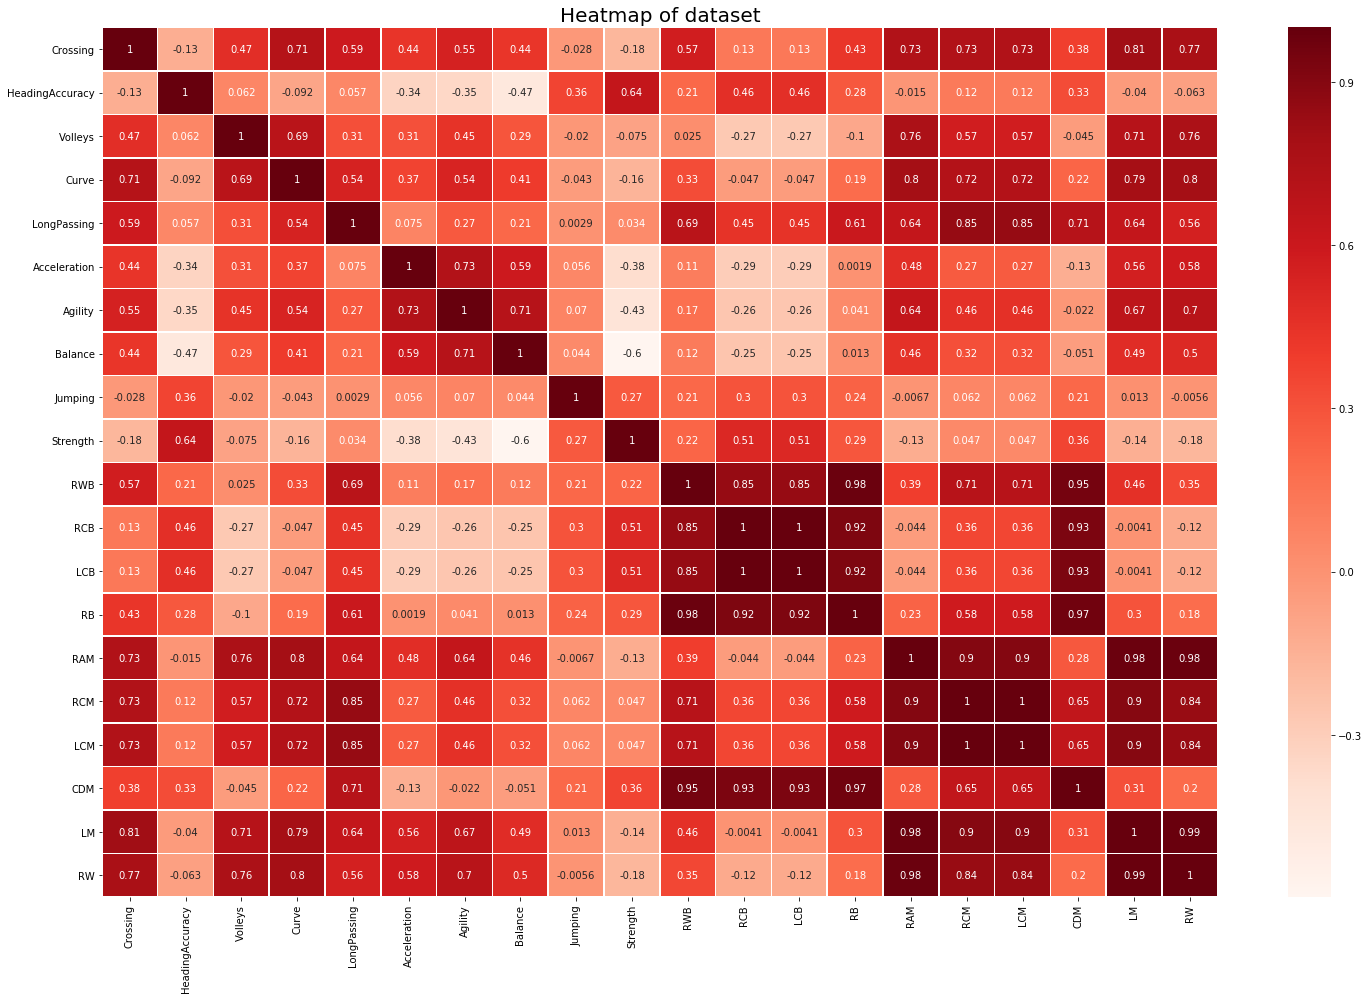

In [95]:
player_characteristics = ['Crossing','Finishing', 'HeadingAccuracy', 
                          'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
                          'FKAccuracy', 'LongPassing', 'BallControl', 
                          'Acceleration', 'SprintSpeed', 'Agility', 'Reactions', 
                          'Balance', 'ShotPower', 'Jumping', 'Stamina', 
                          'Strength', 'LongShots', 'Aggression',
                          'Interceptions', 'Positioning', 'Vision', 
                          'Penalties', 'Composure', 'Marking', 'StandingTackle', 
                          'SlidingTackle']
position_attributes = ['RWB','LWB','RCB','CB', 'LCB', 'LB', 'RB','RM', 'RAM',
                       'RDM', 'RCM', 'LDM', 'LCM', 'CM', 'CDM', 'CAM','LM', 
                       'LAM', 'RW', 'RS', 'RF','LW', 'LS', 'LF','ST', 'CF']

corr_matrix = util_df.corr()

plt.figure(figsize= (25, 16))

hm=sns.heatmap(util_df.loc[:, player_characteristics[0:20:2]+position_attributes[0:20:2]].corr(), annot = True, linewidths=.5, cmap='Reds')
hm.set_title(label='Heatmap of dataset', fontsize=20)
hm;
plt.savefig('heat.png')

## find weak features

In [96]:
# team_name = 'Paris Saint-Germain'
team_name = 'LA Galaxy'

# team feature mean
# team_mean = team_df.loc[team_name, :].mean(axis=0)
team_mean = team_df.loc[team_name, :].quantile([0.25])
print(float(team_mean))
# print(team_df.loc[team_name, :].sort_values(ascending=False))


# weak team features (need to be update)
team_feats_weak = team_df.loc[team_name, team_df.loc[team_name, :] < float(team_mean)].index
print('weak features')
print(np.reshape(np.array(team_feats_weak), (7, 1)))
# team_feats_weak = list(team_df.loc[team_name, :].sort_values(ascending=False).index[-10:])





69.57744997574495
weak features
[['FKAccuracy']
 ['LongPassing']
 ['Interceptions']
 ['Penalties']
 ['Marking']
 ['StandingTackle']
 ['SlidingTackle']]


## find weak positions

In [97]:
# weak position counters
position_counter = Counter()
for idx, feat in enumerate(team_feats_weak):
    top_position = corr_matrix.loc[position_attributes, feat].sort_values(ascending=False).index[:5]
#     print('top', top_position)
    position_counter += Counter(top_position)


# get most related position
weak_positions = []
for item in position_counter.most_common(3):
    weak_positions.append(item[0])

print(weak_positions)

['RCB', 'CB', 'LCB']


## find weak players

In [98]:
weak_players = pd.DataFrame()
team_players = util_df.loc[(util_df.loc[:, 'Club'] == team_name), :]


for idx, position in enumerate(weak_positions):
    team_players_position = team_players.loc[team_players.loc[:, 'Position'] == position, :]
    weak_players = pd.concat([weak_players, team_players_position], ignore_index=True)

print(weak_players)



# df_fcbarcelona = util_df[util_df.Club == team_name]
# plt.figure(figsize = (12,10))

# plt.subplot(211)
# sns.countplot(x = 'Position', data = df_fcbarcelona, palette = 'hls', order=position_attributes);
# plt.title('Count of players by prefered position', fontsize=20);
# plt.xlabel('Prefered position')


       ID              Name  Age    Nationality  Overall  Potential  \
0  209761         D. Steres   27  United States       67         68   
1  137114          M. Ciani   34         France       69         69   
2  188917       J. Skjelvik   26         Norway       66         68   
3  242631  T. Hilliard-Arce   22  United States       64         71   
4  237225       H. Arellano   20  United States       58         70   
5  229879         D. Romney   25  United States       69         73   

        Club  Value Wage  Special  ...  Aggression  Interceptions  \
0  LA Galaxy  €725K  €3K     1495  ...          68             66   
1  LA Galaxy  €325K  €4K     1416  ...          80             71   
2  LA Galaxy  €650K  €2K     1832  ...          67             66   
3  LA Galaxy  €550K  €2K     1370  ...          70             62   
4  LA Galaxy  €200K  €1K     1456  ...          66             57   
5  LA Galaxy  €1.1M  €4K     1638  ...          70             65   

   Positioning Vis

## cluster test

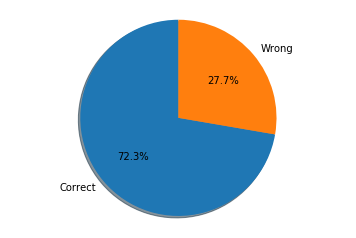

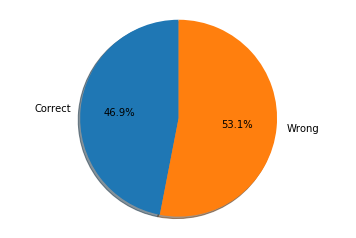

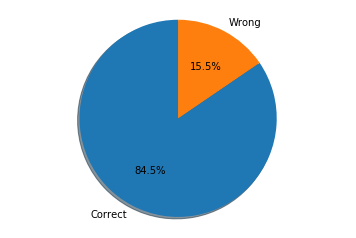

In [85]:

data = pd.read_csv('label.csv', header=None, index_col=None, na_filter=False)
# print(data.head())
cluster = list(data.iloc[:, 1])
gt = list(data.iloc[:, 2])

# print(type(cluster[0]))

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Correct', 'Wrong'

# cluster = [1,2,0,2,0,1,1]
# gt =      [1,2,1,0,2,1,0]

for i in range(3):
    count = 0
    if i == 0:
        for idx, val in enumerate(gt):
            if val == i and cluster[idx] == i:
                count += 1
    elif i == 1:
        for idx, val in enumerate(gt):
            if val == i and cluster[idx] == 2:
                count += 1
    else:
        for idx, val in enumerate(gt):
            if val == i and cluster[idx] == 1:
                count += 1

    sizes = [count, gt.count(i)-count]    
    explode = (0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

#     plt.show()
    plt.savefig('image'+str(i))